In [1]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

# This part allows the graph to be drawn
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [3]:
# Create and wrap the environment

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("Pendulum-v0")
# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
# Create and train the agent

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model = DDPG("MlpPolicy", env, action_noise=action_noise)
# Train the agent
model.learn(total_timesteps=int(200000), callback=callback)

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -1474.67
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 2000
Best mean reward: -1474.67 - Last mean reward per episode: -1424.69
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 3000
Best mean reward: -1424.69 - Last mean reward per episode: -1342.41
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 4000
Best mean reward: -1342.41 - Last mean reward per episode: -1127.55
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 5000
Best mean reward: -1127.55 - Last mean reward per episode: -941.84
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 6000
Best mean reward: -941.84 - Last mean reward per episode: -809.04
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 7000
Best mean reward: -809.04 - Last mean reward per episode: -710.91
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 8000
Best mean reward: -710.91 - La

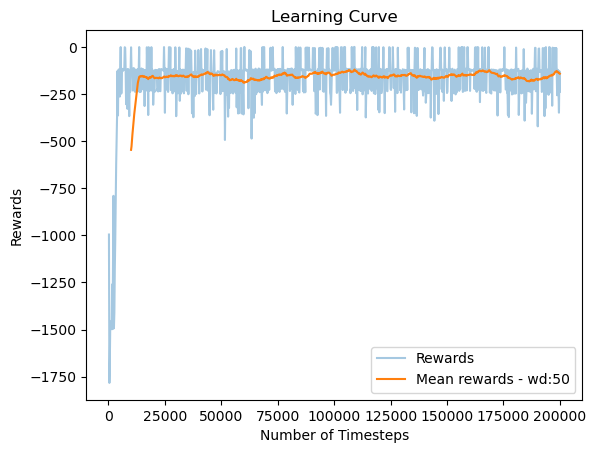

In [5]:
# Plotting

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    
    x, y = ts2xy(load_results(log_folder), 'timesteps')

    y_mean = moving_average(y, window=50)
    # Truncate x
    x_mean = x[len(x) - len(y_mean):]

    fig = plt.figure(title)
    plt.plot(x, y, alpha=0.4, label="Rewards")
    plt.plot(x_mean, y_mean, label="Mean rewards - wd:50")
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title)
    plt.legend(loc="best")
    plt.show()


plot_results(log_dir)

In [6]:
# Test 

scores = []
for i in range(100):
    obs = env.reset()
    score = 0
    done = False
    
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        score += reward
    
    scores.append(score)

np.mean(scores)

-135.19860470204227